# Evaluates embeddings on CelebA

In [1]:
import pandas as pd
import os, re
import numpy as np
import scipy
import glob
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

In [2]:
def mine_matchedPairs(df, k):
    a_idx = np.random.choice(df.index, size=k, replace=True)
    a_identities = df.loc[a_idx, "identity"].values
    l_matched_idx = []
    for i, (idx, identity) in enumerate(zip(a_idx, a_identities)):
        if i%1000==0:
            print(i)
        matched_idx = df.loc[(df["identity"]==identity)&(df.index!=idx)].sample(1).index.values[0]
        l_matched_idx.append(matched_idx)
    a_matched_idx = np.array(l_matched_idx)
    matched_indices = np.stack((a_idx, a_matched_idx), axis=1)
    return matched_indices

def mine_pairs(df_dataset, k_matched=10000, k_unmatched=100):
    # mining matched pairs
    s = df_dataset.loc[df_dataset["retina_n_faces_detected"]==1].groupby("identity").size()>1
    df = df_dataset.loc[df_dataset["identity"].isin(s.index[s.values])&(df_dataset["retina_n_faces_detected"]==1)]
    matched_indices = mine_matchedPairs(df,k_matched)

    # mining unmatched pairs
    df = df.reset_index()[["index", "identity"]]
    df = pd.merge(df.sample(k_unmatched), df.sample(k_unmatched), how="cross")
    df = df[df["identity_x"]!=df["identity_y"]]
    unmatched_indices = df[["index_x", "index_y"]].values
    return matched_indices, unmatched_indices

def estimate_BayesError(a_sim_matched, a_sim_unmatched):
    bw = 0.05
    val_min = min(a_sim_matched.min(), a_sim_unmatched.min())*1.1
    val_max = min(a_sim_matched.max(), a_sim_unmatched.max())*1.1
    x = np.linspace(val_min,val_max,1001).reshape(-1,1)  # model dependent scale

    kde_matched = KernelDensity(bandwidth=bw, kernel="gaussian")
    kde_matched.fit(a_sim_matched.reshape(-1,1))
    density_matched = np.exp(kde_matched.score_samples(x))
    density_matched = density_matched/density_matched.sum()

    kde_unmatched = KernelDensity(bandwidth=bw, kernel="gaussian")
    kde_unmatched.fit(a_sim_unmatched.reshape(-1,1))
    density_unmatched = np.exp(kde_unmatched.score_samples(x))
    density_unmatched = density_unmatched/density_unmatched.sum()

    density_bayes_error = np.minimum(density_matched, density_unmatched)
    bayes_error = density_bayes_error.sum()
    return bayes_error

In [3]:
df_dataset = pd.read_csv(os.path.expanduser("~")+"/tda-face-recognition/data/CelebA/df_dataset.csv")
matched_indices, unmatched_indices = mine_pairs(df_dataset)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [4]:
d = {"sim_matched":[],
    "sim_unmatched":[],
    "bayes_error":[],}
paths_embeddings = glob.glob(os.path.expanduser("~") + "/tda-face-recognition/data/embeddings/CelebA/*.npy")
for path_embeddings in paths_embeddings:
    a_embeddings = np.load(path_embeddings)
    model_name, architecture, _ = re.split("_|\.", os.path.basename(path_embeddings))
    if model_name in ("facenet"):
        distance_function = scipy.spatial.distance.euclidean
    elif model_name in ("arcface", "adaface", "spherefacer", "sphereface2"):
        distance_function = scipy.spatial.distance.cosine
    a_sim_matched = np.array([distance_function(a_embeddings[i], a_embeddings[j]) for (i,j) in matched_indices])
    a_sim_unmatched = np.array([distance_function(a_embeddings[i], a_embeddings[j]) for (i,j) in unmatched_indices])
    d["sim_matched"].append(a_sim_matched)
    d["sim_unmatched"].append(a_sim_unmatched)
    d["bayes_error"].append(estimate_BayesError(a_sim_matched, a_sim_unmatched))

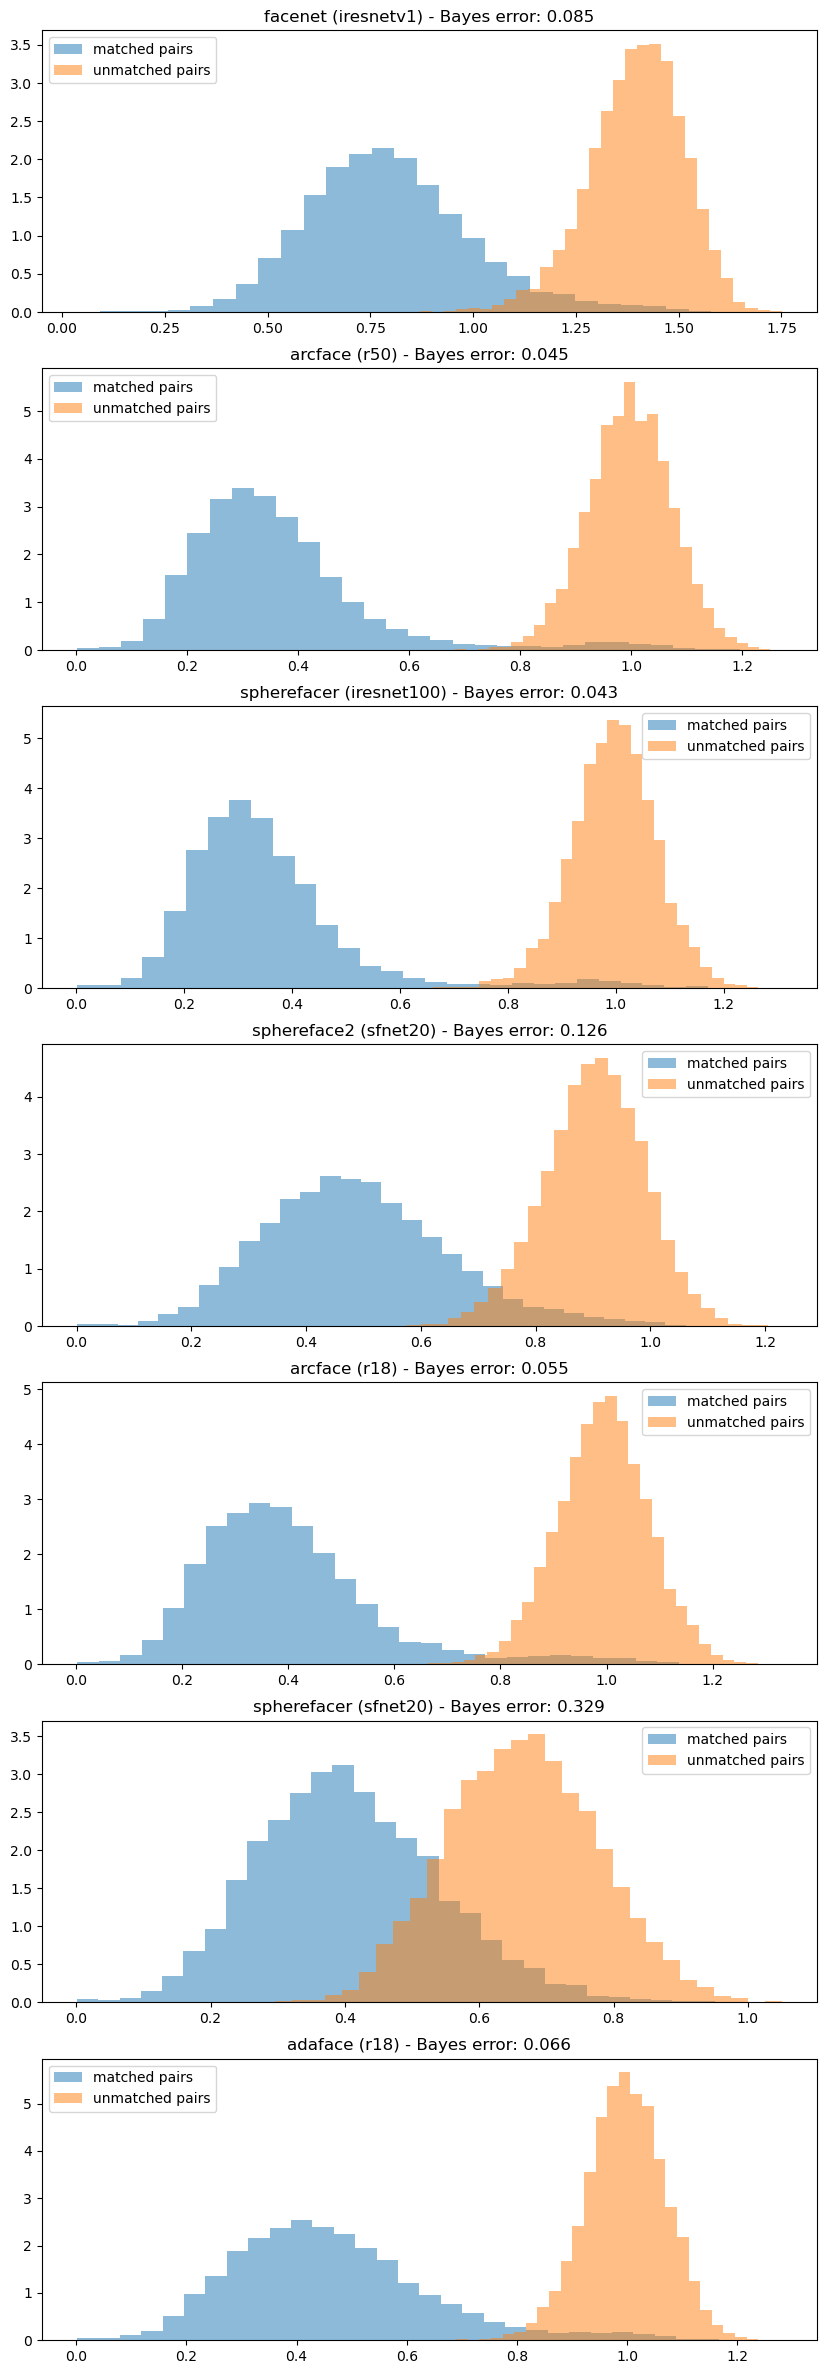

In [5]:
fig, axes = plt.subplots(len(paths_embeddings), figsize=(10,30))
for i, path_embeddings in enumerate(paths_embeddings):
    model_name, architecture, _ = re.split("_|\.", os.path.basename(path_embeddings))
    axes[i].hist(d["sim_matched"][i], bins=30, alpha=0.5, label="matched pairs", density=True)
    axes[i].hist(d["sim_unmatched"][i], bins=30, alpha=0.5, label="unmatched pairs", density=True)
    axes[i].legend()
    axes[i].set_title(f"""{model_name} ({architecture}) - Bayes error: {d["bayes_error"][i]:.3f}""")